# Creating hybrid picture


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
from scipy.fftpack import fft2, fftshift, ifft2

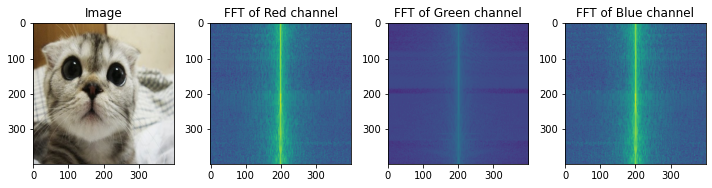

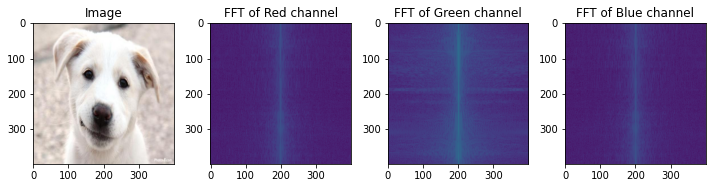

In [7]:
def show(img:np, fft:np):
    channelNames = ["Red", "Green", "Blue"]
    plt.figure(figsize=(10,10))
    if (len(img.shape) == 3):
        plt.subplot(1,4,1)
        plt.imshow(img)
        plt.title("Image")
        for i in range(2,5):
            plt.subplot(1,4,i)
            plt.imshow(fft[:,:,i-2])
            plt.title("FFT of %s channel" % (channelNames[i-2]))
    else:
        plt.subplot(1,2,1)
        plt.imshow(img, cmap="gray")
        plt.title("Image")
        plt.subplot(1,2,2)
        plt.imshow(fft)
        plt.title("FFT of image")
    plt.tight_layout()
    plt.show()

# To see the colored image resualts just comment first two lines and uncomment next two lines
# cat = cv2.imread("cat.jpg",cv2.IMREAD_GRAYSCALE)
# dog = cv2.imread("dog.jpg",cv2.IMREAD_GRAYSCALE)

cat = cv2.cvtColor(cv2.imread("cat.jpg"), cv2.COLOR_BGR2RGB)
dog = cv2.cvtColor(cv2.imread("dog.jpg"), cv2.COLOR_BGR2RGB)

cat = cv2.resize(cat, (400,400))
dog = cv2.resize(dog, (400,400))

catFft = fft2(cat)
catFft = np.log(catFft)
catFft = fftshift(catFft)
catFft = np.abs(catFft)
dogFft = fft2(dog)
dogFft = np.log(dogFft)
dogFft = fftshift(dogFft)
dogFft = np.abs(dogFft)
show(cat, catFft)
show(dog, dogFft)  

In [4]:
def gaussian(s: int, t: int, std: float) -> float:
    x = (s*s + t*t)/(2*std*std)
    return exp(-x)

def gaussianKernel(size: int, std: float) -> np:
    kernel = np.zeros((size, size), np.float32)
    k = 0
    if(size % 2 != 0):
        for s in range(-int(size/2), int(size/2) + 1, 1):
            for t in range(-int(size/2), int(size/2) + 1, 1):
                kernel[int(size/2) + s, int(size/2) + t] = gaussian(s, t, std)
                k += kernel[int(size/2) + s, int(size/2) + t]
        kernel = kernel/k
    return kernel

def conv2D(mat: np, kernel: np) -> np:
    kernel = np.flipud(np.fliplr(kernel))
    kernel_width = kernel.shape[0]
    kernel_height = kernel.shape[1]
    padding = (kernel_width - 1)
    offset = padding // 2
    output = np.zeros_like(mat)
    image_padded = np.zeros((mat.shape[0] + padding, mat.shape[1] + padding))
    image_padded[offset:-offset, offset:-offset] = mat

    for y in range(mat.shape[0]):
        for x in range(mat.shape[1]):
            output[y, x] = np.sum(
                image_padded[y:y+kernel_width, x:x+kernel_height]*kernel)
    return output
    
def gaussianFilter(img: np, sigma: float) -> np:
    n = int(6*sigma)
    if (n % 2 == 0):
        n -= 1
    filter = gaussianKernel(n, sigma)
    res = np.zeros(img.shape)
    if (img.shape[-1] == 3):
        for i in range(3):
            res[:,:,i] = conv2D(img[:,:,i], filter)
    else:
        res = conv2D(img, filter)
    return res

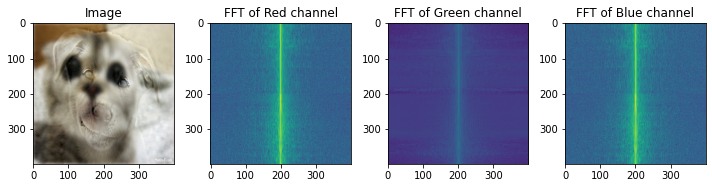

In [8]:
filteredCat = gaussianFilter(cat, 5)
filteredDog = gaussianFilter(dog, 5)

filteredCatFft = fft2(filteredCat)
filteredDogFft = fft2(filteredDog)
dogFft = fft2(dog)
dogHighFreq = dogFft-filteredDogFft
hybridImageFft = filteredCatFft+dogHighFreq

hybridImage = ifft2(hybridImageFft)
hybridImage = np.abs(hybridImage)
hybridImage = hybridImage.astype(np.uint8)
hybridImageFft = fftshift(hybridImageFft)
hybridImageFft = np.log(hybridImageFft)
hybridImageFft = np.abs(hybridImageFft)

show(hybridImage, hybridImageFft)
